# Covid-19 data classification

## Table of content
1. [Data preprocessing](#Data-preprocessing)
2. [Data classification](#Data-classification)
* [K-Nearest Neighbours](#K-Nearest-Neighbours)
* [Naive Bayes](#Naive-Bayes)
* [Decision Tree](#Decision-Tree)
* [Random Forest](#Random-Forest)

In [1]:
import numpy as np
import pandas as pd
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
#from matplotlib.colors import LogNorm
import seaborn as sns
from datetime import timedelta
import datetime
from itertools import cycle
import matplotlib.dates as mdates

## Data preprocessing

In [3]:
url = 'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-05-14.xlsx'
df = pd.read_excel(url)
df['dateRep'] = pd.to_datetime(df['dateRep']).dt.date
df.head(3)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,2020-05-14,14,5,2020,259,3,Afghanistan,AF,AFG,37172386.0,Asia
1,2020-05-13,13,5,2020,280,5,Afghanistan,AF,AFG,37172386.0,Asia
2,2020-05-12,12,5,2020,285,2,Afghanistan,AF,AFG,37172386.0,Asia


In [4]:
df=df.sort_values(by=['countriesAndTerritories', 'dateRep'])
df['cum_cases'] = df.groupby(['countriesAndTerritories'])['cases'].apply(lambda x: x.cumsum())
df['cum_deaths'] = df.groupby(['countriesAndTerritories'])['deaths'].apply(lambda x: x.cumsum())
lista=df[df.cum_cases>df['cum_cases'].max()/20]['countriesAndTerritories'].unique()
lista=np.append(lista,['Poland'])
df[df.countriesAndTerritories.isin(lista)].groupby(['countriesAndTerritories'])[['cases','deaths']].describe(percentiles=[0.1,0.25,0.5,0.75,0.9])

cases                                            \
                          count          mean           std    min    10%   
countriesAndTerritories                                                     
Brazil                    136.0   1389.514706   2622.150508    0.0    0.0   
Canada                    136.0    531.455882    705.936026    0.0    0.0   
China                     136.0    617.823529   1585.323936    0.0    0.0   
France                    136.0   1034.808824   1538.769256    0.0    0.0   
Germany                   136.0   1266.463235   1831.618543    0.0    0.0   
India                     135.0    577.800000   1041.404088    0.0    0.0   
Iran                      136.0    828.860294    959.150876    0.0    0.0   
Italy                     136.0   1633.117647   1918.915110    0.0    0.0   
Peru                       68.0   1122.147059   1296.339476    0.0    6.0   
Poland                     70.0    245.771429    150.849303    1.0   17.1   
Russia                    136.0   1781.404412   3337.727667    0.0    0.0   
Spain                     135.0   1694.007407   2475.098022 -713.0    0.0   
Turkey                     62.0   2308.290323   1496.575680    1.0  178.9   
United_Kingdom            136.0   1689.007353   2236.722948    0.0    0.0   
United_States_of_America  136.0  10226.073529  13255.681130    0.0    0.0   

                                                                      deaths  \
                              25%     50%       75%      90%      max  count   
countriesAndTerritories                                                        
Brazil                       0.00     3.0   1496.75   5449.5  11385.0  136.0   
Canada                       0.00     6.0   1255.25   1581.0   2760.0  136.0   
China                       14.75    66.0    398.00   2073.5  15141.0  136.0   
France                       0.00   164.0   1614.00   3823.5   7578.0  136.0   
Germany                      0.00   102.0   2120.75   4285.5   6294.0  136.0   
India                        0.00     2.0    784.50   1991.8   4213.0  135.0   
Iran                         0.00   669.0   1367.25   1984.5   5275.0  136.0   
Italy                        0.00   773.5   3041.00   4681.0   6557.0  136.0   
Peru                        35.00   656.0   1766.75   3342.9   4247.0   68.0   
Poland                     112.00   276.5    344.75    422.3    595.0   70.0   
Russia                       0.00     0.0   1511.00   6755.0  11656.0  136.0   
Spain                        0.00   183.0   2933.50   5563.0   9181.0  135.0   
Turkey                    1543.00  2168.0   3144.75   4345.8   5138.0   62.0   
United_Kingdom               0.00    45.5   3987.75   5054.0   8719.0  136.0   
United_States_of_America     0.00   100.0  24129.00  30032.5  48529.0  136.0   

                                                                        \
                                mean         std  min  10%   25%   50%   
countriesAndTerritories                                                  
Brazil                     96.683824  188.201142  0.0  0.0   0.0   0.0   
Canada                     39.000000   63.391669  0.0  0.0   0.0   0.0   
China                      34.095588  116.240229  0.0  0.0   0.0   4.0   
France                    199.073529  338.291297  0.0  0.0   0.0   2.5   
Germany                    56.786765   86.413254  0.0  0.0   0.0   0.0   
India                      18.881481   35.383412  0.0  0.0   0.0   0.0   
Iran                       49.875000   57.118128  0.0  0.0   0.0  16.0   
Italy                     228.720588  275.423356  0.0  0.0   0.0  45.0   
Peru                       31.897059   35.511671  0.0  0.0   1.0  14.5   
Poland                     12.300000   10.749250  0.0  0.0   1.0  13.0   
Russia                     16.264706   30.737415  0.0  0.0   0.0   0.0   
Spain                     200.770370  284.132457  0.0  0.0   0.0   0.0   
Turkey                     63.741935   41.194037  0.0  3.2  18.5  66.5   
United_Kingdom

## Data classification
### How many max daily cases and cumulated deaths must have a country to classify it as the most affected?

In [5]:
df=df.dropna()
grouped = df.groupby('countriesAndTerritories')[['cases','deaths','cum_cases','cum_deaths']].max() #,df.groupby('countriesAndTerritories')['cum_'].max()
X=grouped.loc[:, ['cases', 'cum_deaths']].values
y=[]

for i in grouped.cases:
    if i> grouped.cum_cases.max()/500:
        y.append(1)
    else:
        y.append(0)

In [25]:
from matplotlib.colors import ListedColormap
def vis(X,y, title, step=10):
    plt.figure(figsize=(15,7))
    markers = ('o', 'x')
    X1, X2 = np.meshgrid(np.arange(start = X[:, 0].min() - 1, stop = X[:, 0].max() + 1, step = 100), np.arange(start = X[:, 1].min() - 1, stop = X[:, 1].max() + 1, step = step))
    plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), alpha = 0.4, cmap = ListedColormap(('green', 'red')))
    plt.xlim(X1.min(), np.percentile(X1, 25))
    plt.ylim(X2.min(), np.percentile(X2, 25))
    for i, j in enumerate(np.unique(y)):
        plt.scatter(X[y == j, 0], X[y == j, 1],alpha= 0.5, c = np.array([ListedColormap(('green', 'darkred'))(i)]), marker=markers[i], label = j)
    plt.title(title, fontsize=18)
    plt.xlabel('Maximum Daily Cases', fontsize=12)
    plt.ylabel('Cumulated Deaths', fontsize=12)
    for cntr in ['Poland', 'Russia', 'Germany', 'Belgium', 'Belarus','France', 'Iran', 'Chile', 'Turkey','Switzerland', 'India', 'Canada', 'Brazil']:
        if grouped.loc[cntr,'cum_deaths']<np.percentile(X2, 25):
            plt.text(grouped.loc[cntr, 'cases'], grouped.loc[cntr,'cum_deaths'], cntr, size=10, color='black', alpha=0.9)
    plt.legend()
    plt.show()

## K-Nearest Neighbours

In [26]:
from sklearn.neighbors import KNeighborsClassifier
classifier= KNeighborsClassifier(n_neighbors=5)
classifier.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

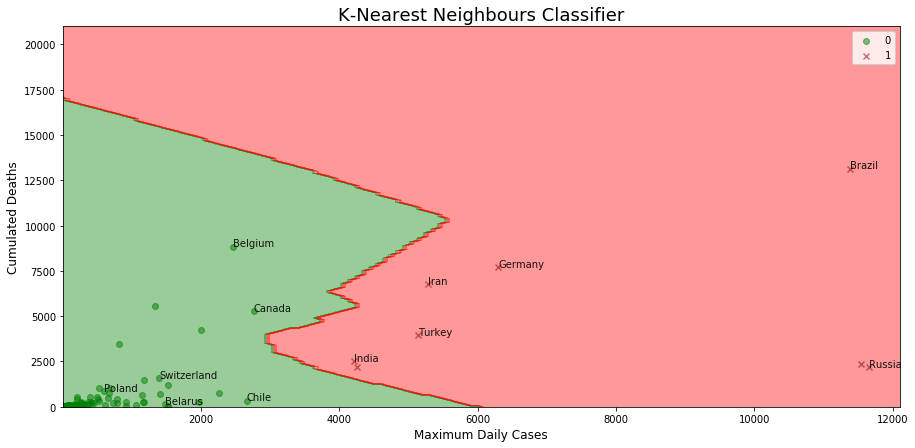

In [27]:
vis(X,y, 'K-Nearest Neighbours Classifier', step=100)

## Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB
classifier=GaussianNB()
classifier.fit(X, y)

GaussianNB(priors=None, var_smoothing=1e-09)

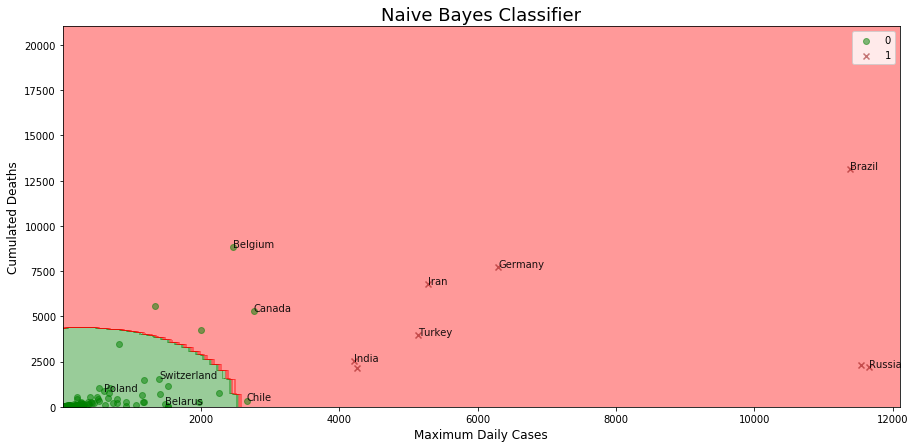

In [29]:
vis(X,y, 'Naive Bayes Classifier')

## Decision Tree

In [30]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

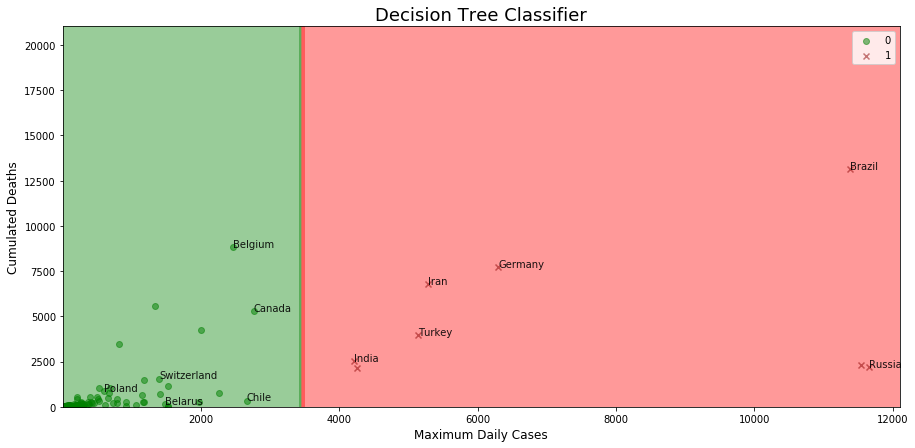

In [32]:
vis(X,y, 'Decision Tree Classifier')

## Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
classifier.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

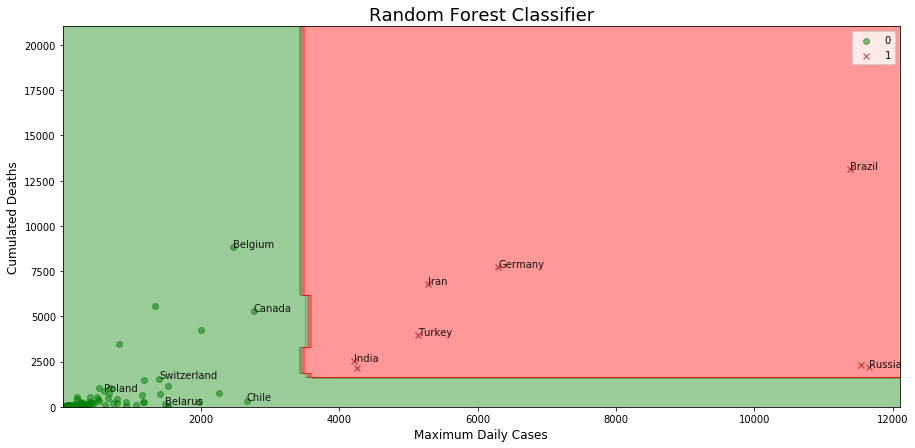

In [34]:
vis(X,y, 'Random Forest Classifier')